In [5]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage import feature
from skimage.morphology import binary_erosion
import torch


In [46]:
def getBorderColor(img):
    
    border = np.asarray(img[0,:])
    border = np.concatenate((border, np.asarray(img[-1, :])))
    border = np.concatenate((border, np.asarray(img[:, 0])))
    border = np.concatenate((border, np.asarray(img[:, -1])))
    return np.bincount(border).argmax()


def pre_processing(img):
    _, img_binarized = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)    
    if(getBorderColor(img_binarized) != 0):
        img_binarized = cv2.bitwise_not(img_binarized) 
    return img_binarized



def showImage(img):
    plt.imshow(img, cmap='gray')
    plt.show()    


In [ ]:
def getFeaturesHOG(img):
   img = cv2.resize(img, (256, 128))
   cell_size = (32, 32)  # h x w in pixels
   block_size = (2, 2)  # h x w in cells
   nbins = 9  # number of orientation bins
   # winSize is the size of the image cropped to an multiple of the cell size
   hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                    img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

   hog_feats = hog.compute(img)
   return hog_feats.flatten()  



In [65]:
def getFeaturesVP(img):
    #img = cv2.resize(img, (256, 256))
    img = cv2.Canny(img, 100, 200)
    #showImage(img)
    # wihch is about 10% of image height
    MIN_LINE_PIXELS = int(0.10 * img.shape[0])
    lines = cv2.HoughLinesP(img, 1, np.pi/180, MIN_LINE_PIXELS, None, MIN_LINE_PIXELS, 0)
    v_lines_lengths = []
    h_lines_lengths = []
    
    if lines is not None:
            for line in lines:
                x1,y1,x2,y2 = line[0]
                #print(x1, y1, x2, y2)
                cv2.line(img,(x1,y1),(x2,y2),20,2)
                # vertical lines
                if x1 == x2:
                    v_lines_lengths.append(abs(y2-y1))
                # horizontal    
                elif y1 == y2:
                    h_lines_lengths.append(abs(x2-x1))
                # else:
                #     continue
                # cv2.line(img, (x1,y1), (x2,y2), 50, 2)    

    #showImage(img)
    v_lines_lengths = np.asarray(v_lines_lengths)
    h_lines_lengths = np.asarray(h_lines_lengths)  
    
    v_lines_count = v_lines_lengths.shape[0]
    h_lines_count = h_lines_lengths.shape[0]
    
    # normalize heights of the vertical lines with respect to image height
    v_lines_lengths = v_lines_lengths/img.shape[0]

    if v_lines_count:
        LVL = max(v_lines_lengths)
        avg_v_line = np.mean(v_lines_lengths)
        LVL_diff_avg = LVL - avg_v_line
        variance_v_lines = np.var(v_lines_lengths)
    else:
        LVL = 0
        avg_v_line = 0
        LVL_diff_avg = 0
        variance_v_lines = 0
    return [v_lines_count, h_lines_count, LVL, avg_v_line, LVL_diff_avg, variance_v_lines]


# Read Data, Split Training, Validation, Test

In [66]:
data_set = []
Y = []
for i in range(1, 10):
    for filename in os.listdir("ACdata_base/" + str(i)):
        img = cv2.imread(os.path.join("ACdata_base/" + str(i),filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            data_set.append(pre_processing(img))
            Y.append(i)
            
X_train, X_testValid, Y_train, Y_testValid = train_test_split(data_set, Y, test_size=0.4, random_state=42)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_testValid, Y_testValid, test_size=0.5, random_state=42)            

In [68]:
# img = data_set[1600]
# print(getFeaturesVP(img))

[10, 10, 0.5, 0.32127659574468087, 0.17872340425531913, 0.02756450882752377]


In [69]:
f1 = []
for i in range(len(data_set)):
    f1.append(getFeaturesVP(data_set[i])) 
#print(len(f1))


In [70]:
# print(f1[1600])

In [38]:
def getFeatures(images):
   x_features = []
   for i in range(len(images)):
        x_features.append(getFeaturesHOG(images[i]))
   return np.asarray(x_features)

In [39]:
train_features = getFeatures(X_train)
validation_features = getFeatures(X_validation)
test_features = getFeatures(X_test)


print(train_features.shape)
print(len(Y_train))

print(validation_features.shape)
print(len(Y_validation))

print(test_features.shape)
print(len(Y_test))


(1011, 756)
1011
(337, 756)
337
(337, 756)
337


In [40]:
# H is hidden dimension; D_out is output dimension.
N, D_in, H1, D_out = train_features.shape[0], train_features.shape[1], 512, 9

x = torch.tensor(train_features).double()
y = torch.tensor(Y_train)
y = y-1 #output layer nodes indices [0:8] not [1:9]

x_validation = torch.tensor(validation_features).double()
Y_validation = torch.tensor(Y_validation)
Y_validation = Y_validation - 1

x_test = torch.tensor(test_features).double()
y_test = torch.tensor(Y_test)
y_test = y_test - 1

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, D_out),
    torch.nn.LogSoftmax(dim=1)
)

loss_fn = torch.nn.NLLLoss()

learning_rate = 5*1e-5


model.to(device)
model.double()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
validation_losses = []

In [55]:
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

for t in range(2000):

    #print(t)
    x = x.to(device)
    y = y.to(device)
    
    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item(),"  [Training]")
        training_losses.append(loss.item())
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 100 == 99:
        with torch.no_grad():
            x_valid = x_validation.to(device)
            y_valid = Y_validation.to(device)
            y_pred2 = model(x_valid)
            loss = loss_fn(y_pred2, y_valid)
            print(t, loss.item(),"  [Validation]" )
            validation_losses.append(loss.item())


99 1.418710801764868   [Training]
99 1.4101692389650486   [Validation]
199 0.9464333416326796   [Training]
199 0.9810289450989643   [Validation]
299 0.6878903740671647   [Training]
299 0.7571108421187897   [Validation]
399 0.5333189317474448   [Training]
399 0.6277693003334123   [Validation]
499 0.432509765171366   [Training]
499 0.5457869029031185   [Validation]
599 0.3619081832006586   [Training]
599 0.4907307339486155   [Validation]
699 0.30909350568283184   [Training]
699 0.45177197509597833   [Validation]
799 0.2674504934023507   [Training]
799 0.42303578945608766   [Validation]
899 0.23332601980493653   [Training]
899 0.4010807928825268   [Validation]
999 0.2046108812807776   [Training]
999 0.38396850503536   [Validation]
1099 0.17998833846903045   [Training]
1099 0.37050908280880257   [Validation]
1199 0.15861492444008607   [Training]
1199 0.3598446874798658   [Validation]
1299 0.1398993958331403   [Training]
1299 0.35138646442773164   [Validation]
1399 0.12344135705688722   [Tr

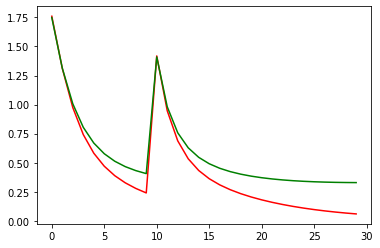

In [56]:
plt.plot(training_losses, '-r')
plt.plot(validation_losses, '-g')
plt.show()         

In [57]:
with torch.no_grad():
    y_pred = model(x)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y).item() / len(y)) * 100
    print("Training Accuracy = ", acc, "%")    

    x_valid = x_validation.to(device)
    y_valid = Y_validation.to(device)
    y_pred = model(x_valid)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y_valid).item() / len(y_valid)) * 100
    print("Validation Accuracy = ", acc, "%")

    x_test = x_test.to(device)
    y_test = y_test.to(device)

    y_pred = model(x_test)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y_test).item() / len(y_test)) * 100
    print("Test Accuracy = ", acc, "%")

Training Accuracy =  99.70326409495549 %
Validation Accuracy =  89.02077151335311 %
Test Accuracy =  91.3946587537092 %
